## Problem 1

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

Time to maturity:  0.038356164383561646


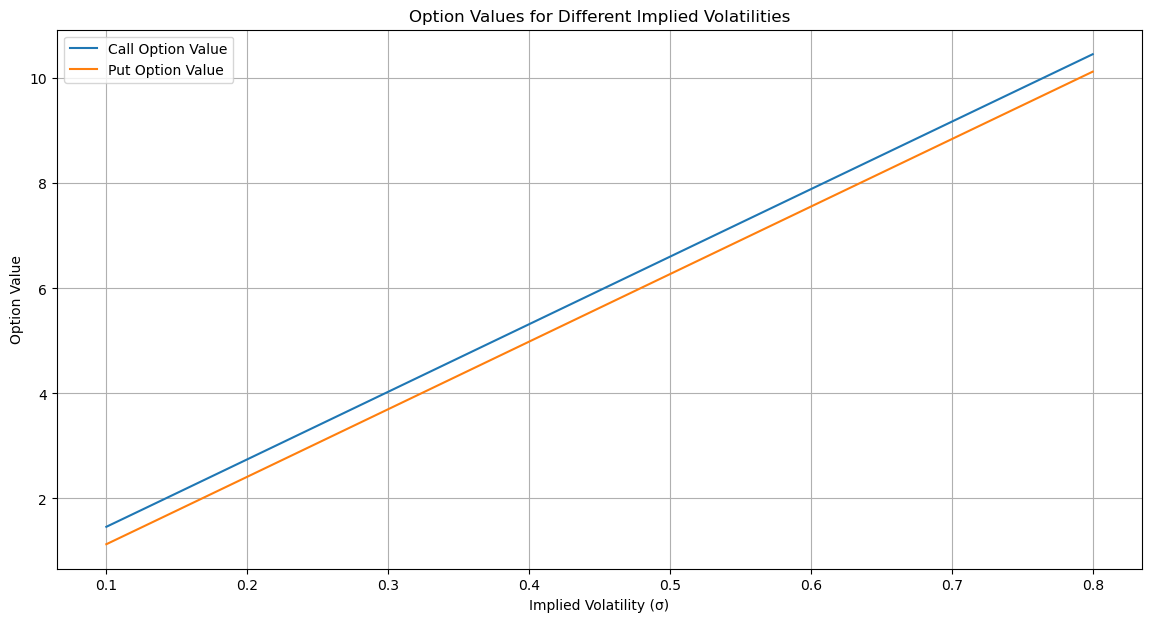

In [10]:
# Function to calculate time to maturity using calendar days
def calculate_ttm(curr_date, expire_date):
    days_to_expiration = (expire_date - curr_date).days
    return days_to_expiration / 365

# Function to calculate d1 and d2
def calculate_d1_d2(S0, X, r, T, sigma):
    d1 = (np.log(S0 / X) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

# Function to calculate both call and put option values using Black-Scholes
def BS_option_values(S0, X, r, T, sigma):
    d1, d2 = calculate_d1_d2(S0, X, r, T, sigma)
    call_value = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    put_value = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return call_value, put_value

# Given dates
current_date = datetime.strptime('03/03/2023', '%m/%d/%Y')
expiration_date = datetime.strptime('03/17/2023', '%m/%d/%Y')

# Given data
S0 = 165  # Current stock price
X = S0    # We'll assume that the strike price is the same as the current stock price for simplicity
r = 0.0525  # Risk-free rate

# Calculate time to maturity
T = calculate_ttm(current_date, expiration_date)
print("Time to maturity: ", T)

# Range of implied volatilities from 10% to 80%
sigma_range = np.linspace(0.1, 0.8, 100)

# Calculate option values for the range of volatilities using the new function
option_values = [BS_option_values(S0, X, r, T, sigma) for sigma in sigma_range]
call_values, put_values = zip(*option_values)  # This unzips the list of tuples into two lists

# Plotting the results with the new functions
plt.figure(figsize=(14, 7))
plt.plot(sigma_range, call_values, label='Call Option Value')
plt.plot(sigma_range, put_values, label='Put Option Value')
plt.title('Option Values for Different Implied Volatilities')
plt.xlabel('Implied Volatility (σ)')
plt.ylabel('Option Value')
plt.legend()
plt.grid(True)
plt.show()

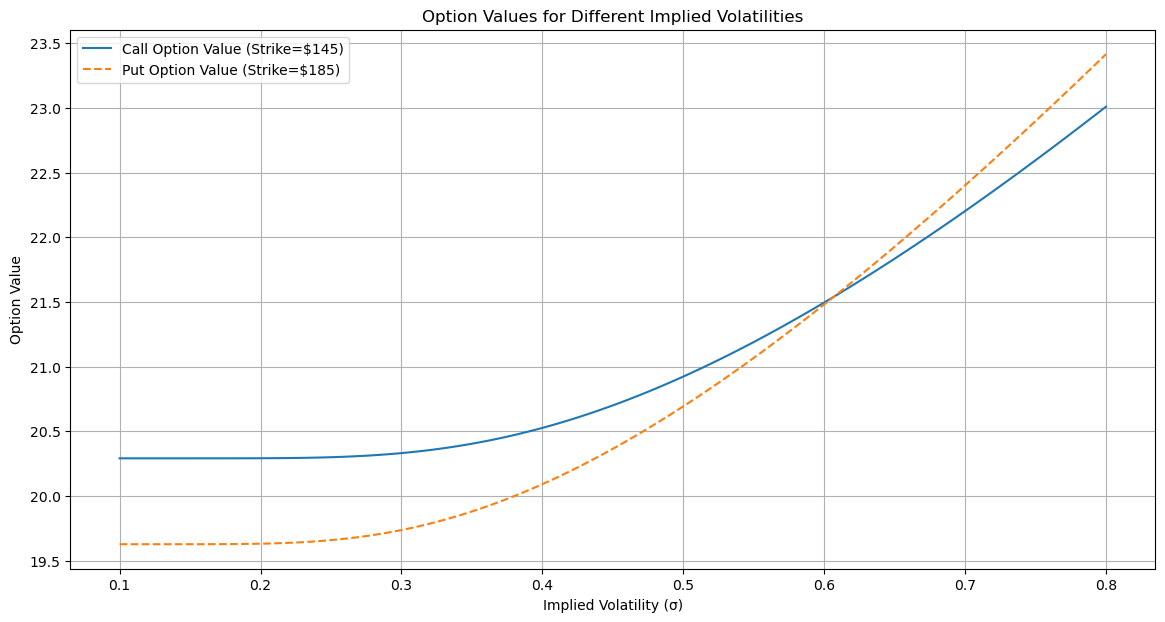

In [8]:
# Let's take a strike price below and above the current stock price for call and put respectively to illustrate
call_strike = 145  # Below the current stock price, to represent an ITM call option
put_strike = 185   # Above the current stock price, to represent an OTM put option

# Calculate option values for the selected strike prices and volatility range
call_values = [BS_option_values(S0, call_strike, r, T, sigma)[0] for sigma in sigma_range]
put_values = [BS_option_values(S0, put_strike, r, T, sigma)[1] for sigma in sigma_range]

# Plotting the results for the selected strike prices
plt.figure(figsize=(14, 7))

plt.plot(sigma_range, call_values, label=f'Call Option Value (Strike=${call_strike})')
plt.plot(sigma_range, put_values, label=f'Put Option Value (Strike=${put_strike})', linestyle='--')

plt.title('Option Values for Different Implied Volatilities')
plt.xlabel('Implied Volatility (σ)')
plt.ylabel('Option Value')
plt.legend()
plt.grid(True)
plt.show()

## Problem 2

/usr/local/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


   Stock  Expiration  Type  Strike  Last Price  Implied Volatility
0   AAPL  12/15/2023  Call     140       30.95            0.044813
1   AAPL  12/15/2023  Call     145       26.74            0.340517
2   AAPL  12/15/2023  Call     150       22.80            0.373077
3   AAPL  12/15/2023  Call     155       18.40            0.344828
4   AAPL  12/15/2023  Call     160       14.15            0.313586
5   AAPL  12/15/2023  Call     165       10.55            0.299043
6   AAPL  12/15/2023  Call     170        7.21            0.275727
7   AAPL  12/15/2023  Call     175        4.63            0.261042
8   AAPL  12/15/2023  Call     180        2.67            0.246144
9   AAPL  12/15/2023  Call     185        1.40            0.235265
10  AAPL  12/15/2023  Call     190        0.69            0.229456
11  AAPL  12/15/2023   Put     140        0.61            0.378308
12  AAPL  12/15/2023   Put     145        0.92            0.360580
13  AAPL  12/15/2023   Put     150        1.36            0.34

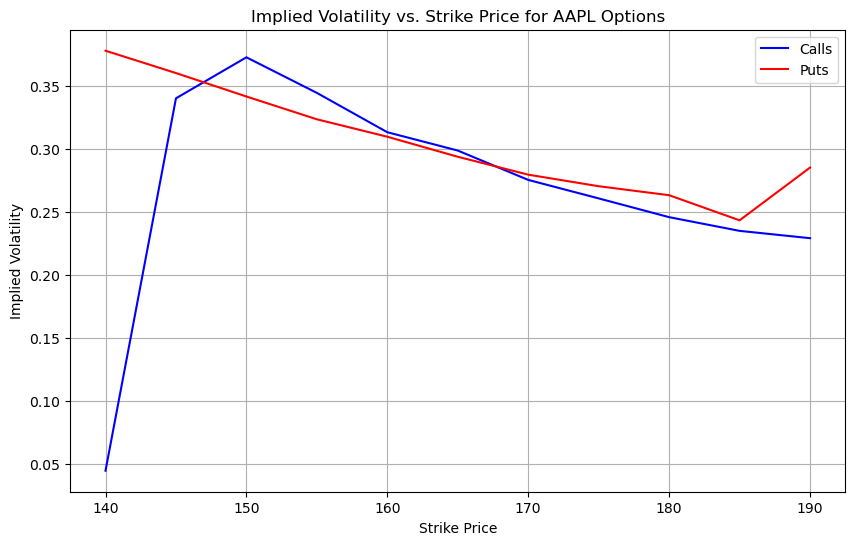

In [13]:
from scipy.stats import norm
from scipy.optimize import fsolve

# modified the BS_option_values
def BS_option_values(S0, X, r, T, sigma, option_type="call"):
    d1, d2 = calculate_d1_d2(S0, X, r, T, sigma)
    if option_type == "call":
        call_value = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
        return call_value
    elif option_type == "put":
        put_value = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        return put_value

# Function to find the implied volatility using fsolve
def find_implied_volatility(S, K, T, r, q, market_price, option_type):
    objective_function = lambda sigma: BS_option_values(S, K, r, T, sigma, option_type) - market_price
    implied_vol = fsolve(objective_function, 0.2)[0]  # starting with an initial guess of 0.2
    return implied_vol

# Given parameters
current_price = 170.15  # Current AAPL price
current_date = pd.to_datetime("2023-10-30")  # Current Date
risk_free_rate = 0.0525  # Risk Free Rate
dividend_yield = 0.0057  # Dividend Rate

# Load the options data
options_data = pd.read_csv("AAPL_Options.csv")

# Calculate the implied volatility for each option
for i in range(len(options_data)):
    S = current_price
    K = options_data.loc[i, 'Strike']
    T = (pd.to_datetime(options_data.loc[i, 'Expiration']) - current_date).days / 365
    r = risk_free_rate - dividend_yield  # Subtracting dividend yield as b = r - q
    market_price = options_data.loc[i, 'Last Price']
    option_type = options_data.loc[i, 'Type'].lower()
    
    # Calculate implied volatility
    options_data.loc[i, 'Implied Volatility'] = find_implied_volatility(S, K, T, r, dividend_yield, market_price, option_type)

print(options_data)

# Sort the data by strike price
calls_data_sorted = options_data[options_data['Type'] == 'Call'].sort_values(by='Strike')
puts_data_sorted = options_data[options_data['Type'] == 'Put'].sort_values(by='Strike')

# Plot implied volatility with respect to strike prices using line plots in one graph
plt.figure(figsize=(10, 6))

# Call options plot
plt.plot(calls_data_sorted['Strike'], calls_data_sorted['Implied Volatility'], 'b-', label='Calls')

# Put options plot
plt.plot(puts_data_sorted['Strike'], puts_data_sorted['Implied Volatility'], 'r-', label='Puts')

plt.title('Implied Volatility vs. Strike Price for AAPL Options')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()